In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import math

In [2]:
# Load data
loaded_df = pd.read_hdf('../data/sample_otu_arrays.h5', key='df')

# Set random seed
np.random.seed(42)

# Split indices into train/test
train_idx, test_idx = train_test_split(loaded_df.index, test_size=0.2, random_state=42)

# Create train and test dataframes
train_df = loaded_df.loc[train_idx]
test_df = loaded_df.loc[test_idx]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print("\nFirst few training samples:")
print(train_df.head())

# Let's also look at array lengths
array_lengths = [len(x) for x in loaded_df['otu_arrays']]
print(f"\nMin array length: {min(array_lengths)}")
print(f"Max array length: {max(array_lengths)}")
print(f"Mean array length: {np.mean(array_lengths):.2f}")

Train size: 6486
Test size: 1622

First few training samples:
                                                            otu_arrays
Unnamed: 0                                                            
SRR044975.SRS011167  [30, 58, 82, 89, 93, 98, 99, 104, 117, 120, 12...
SRR049604.SRS049164  [9, 10, 11, 14, 15, 16, 17, 20, 28, 30, 31, 32...
SRR331714.SRS076947  [19, 30, 43, 58, 65, 70, 71, 74, 80, 90, 92, 9...
SRR089999.SRS077685  [12, 14, 18, 20, 22, 38, 45, 67, 68, 76, 88, 1...
SRR048091.SRS021563  [19, 30, 45, 52, 58, 60, 65, 70, 74, 80, 90, 9...

Min array length: 3
Max array length: 277
Mean array length: 69.10


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class OTUDataset(Dataset):
    def __init__(self, df, pad_token_id=0):
        self.df = df
        self.pad_token_id = pad_token_id
        
        # Find max sequence length for padding
        self.max_len = max(len(x) for x in df['otu_arrays'])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        array = self.df.iloc[idx]['otu_arrays']
        
        # Create padded sequence
        padded = torch.full((self.max_len,), self.pad_token_id, dtype=torch.long)
        padded[:len(array)] = torch.tensor(array, dtype=torch.long)
        
        # Create padding mask (True/1 for real tokens, False/0 for padding)
        # to match model's convention. model internally inverts to match pytorch transformer expectation.
        padding_mask = torch.ones(self.max_len, dtype=torch.bool)
        padding_mask[len(array):] = False
        
        return {
            'input_ids': padded,
            'padding_mask': padding_mask,
            'seq_len': len(array)
        }

# Create datasets
train_dataset = OTUDataset(train_df, pad_token_id=0)
test_dataset = OTUDataset(test_df, pad_token_id=0)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify shapes
for i in train_loader:
   print(i['input_ids'].shape)
   print(i['padding_mask'].shape)
   print(i['seq_len'])
   break

# Get vocab size (maximum token ID + 1 for padding)
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
print(f"\nVocabulary size: {vocab_size}")

torch.Size([16, 277])
torch.Size([16, 277])
tensor([ 74,  63, 153, 141,  23,  72,  87,  86,  25,  95, 118, 105, 135,  11,
         64,  43])

Vocabulary size: 519


In [4]:
import importlib
import model_arch
import scheduler
importlib.reload(model_arch)
importlib.reload(scheduler)


from model_arch import simplifiedV2
from scheduler import AdaptiveSchedule

In [5]:


def train_step(model, batch, scheduler, optimizer):
    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Sample random timesteps for training
    timesteps = scheduler.sample((batch_size,)).to(input_ids.device)  # Shape: [batch_size]
         
    # Forward pass through model
    logits = model(
        input_ids,
        t=timesteps,
        padding_mask=padding_mask
    )
    
    # Calculate token-level losses (no reduction)
    token_losses = nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1),
        ignore_index=0,  # Ignore padding tokens
        reduction='none'
    )
    
    # Reshape token losses to [batch_size, seq_len]
    token_losses = token_losses.view(batch_size, seq_len)
    
    # Create mask to exclude padding tokens (1 for real tokens, 0 for padding)
    mask = (input_ids != 0).float()
    
    # Calculate per-sequence average loss
    seq_lengths = mask.sum(dim=1)
    per_seq_losses = (token_losses * mask).sum(dim=1) / seq_lengths.clamp(min=1)
    
    # Use the mean of per-sequence losses as the main loss
    # This treats each sequence equally regardless of length
    batch_loss = per_seq_losses.mean()
    
    # Add per-sequence losses to scheduler
    with torch.no_grad():
        scheduler.add_data(
            per_seq_losses,
            timesteps
        )
    
    # Backprop with gradient clipping
    optimizer.zero_grad()
    batch_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    return batch_loss.item(), per_seq_losses.mean().item()

def eval_step(model, batch):
    """Single evaluation step for CDCD model
    
    Args:
        model: CDCDModel instance
        batch: Dictionary containing input_ids and padding_mask
        
    Returns:
        loss: scalar evaluation loss
        entropy: entropy statistics
    """
    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Get tmin and tmax from scheduler
    tmin = scheduler.tmin
    tmax = scheduler.tmax
    
    # Uniform random sampling between tmin and tmax
    timesteps = tmin + (tmax - tmin) * torch.rand(batch_size, device=input_ids.device)
    
    # Forward pass through model
    logits = model(
        input_ids,
        t=timesteps,
        padding_mask=padding_mask
    )
    
    # Calculate cross entropy loss (ignoring padding)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1)
    )
    
    # Calculate entropy
    probs = F.softmax(logits, dim=-1)
    eps = 1e-8
    probs = torch.clamp(probs, min=eps, max=1-eps)
    entropy = -(probs * torch.log(probs)).sum(dim=-1)
    
    return loss.item(), entropy.mean().item()

In [6]:
def run_epoch(model, dataloader, scheduler, optimizer, train_run=True, epoch_num=None):
    """Runs one epoch of training or evaluation for the CDCD model"""
    model.train() if train_run else model.eval()
    total_loss = 0
    total_entropy = 0
    num_batches = 0
    
    # Setup progress bar
    mode = "Train" if train_run else "Eval"
    epoch_str = f"Epoch {epoch_num}" if epoch_num is not None else mode
    pbar = tqdm(total=len(dataloader), desc=f"{epoch_str} Loss: 0.0000, Entropy: 0.0000")
    device = next(model.parameters()).device

    # Main loop
    for batch in dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        if train_run:
            loss, entropy = train_step(model, batch, scheduler, optimizer)
        else:
            # Use separate eval step without optimizer/scheduler
            loss, entropy = eval_step(model, batch)
        
        # Accumulate metrics
        total_loss += loss
        total_entropy += entropy
        num_batches += 1
        
        # Update progress bar
        avg_loss = total_loss / num_batches
        avg_entropy = total_entropy / num_batches
        pbar.set_description(f"{epoch_str} Loss: {avg_loss:.4f}, Entropy: {avg_entropy:.4f}")
        pbar.update(1)
    
    pbar.close()
    
    # Calculate final averages
    avg_loss = total_loss / num_batches
    avg_entropy = total_entropy / num_batches
    
    # Update scheduler parameters if training
    if train_run and epoch_num>10:
        scheduler.update_optimal_parameters(history=10_000)
    
    return {
        "loss": avg_loss,
        "entropy": avg_entropy,
        "num_batches": num_batches
    }

In [7]:
def train_simple(
    model,
    train_dataloader,
    eval_dataloader,
    noise_scheduler,
    num_epochs,
    learning_rate=1e-4,
    patience=5,
    save_dir="checkpoints",
    device="cuda"
):
    """Simple training loop with basic LR reduction on plateau
    """
    import torch
    from pathlib import Path
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    best_eval_loss = float('inf')
    epochs_without_improvement = 0
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    model = model.to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        train_metrics = run_epoch(
            model=model,
            dataloader=train_dataloader,
            scheduler=noise_scheduler,
            optimizer=optimizer,
            train_run=True,
            epoch_num=epoch+1
        )
        
        # Evaluation phase
        eval_metrics = run_epoch(
            model=model,
            dataloader=eval_dataloader,
            scheduler=noise_scheduler,
            optimizer=optimizer,
            train_run=False,
            epoch_num=epoch+1
        )
        
        # Save best model and handle early stopping
        if eval_metrics['loss'] < best_eval_loss:
            best_eval_loss = eval_metrics['loss']
            epochs_without_improvement = 0
            
            torch.save(model.state_dict(), save_dir / 'best_model.pt')
        else:
            epochs_without_improvement += 1
            
            # Reduce learning rate if no improvement
            if epochs_without_improvement == patience:
                current_lr = optimizer.param_groups[0]['lr']
                new_lr = current_lr / 2
                for param_group in optimizer.param_groups:
                    param_group['lr'] = new_lr
                epochs_without_improvement = 0
                print(f"Reducing learning rate to {new_lr}")
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Eval Loss: {eval_metrics['loss']:.4f}")
    
    # Load best model
    #model.load_state_dict(torch.load(save_dir / 'best_model.pt'))
    return model

In [8]:
import importlib
import model_arch
import scheduler
importlib.reload(model_arch)
importlib.reload(scheduler)

from model_arch import simplifiedV2
from scheduler import AdaptiveSchedule

In [9]:
# Model hyperparameters
hidden_dim = 32  # Dimension of hidden layers
embedding_dim = 32  # Dimension of embeddings, default 32
transformer_dim = 64 #embedding_dim
num_heads = 16  # Number of attention heads
num_layers = 3  # Number of transformer layers
t_min = 1 # Minimum time value
t_max = 50  # To high breaks scheduler. This value really depends on embed dim: SNR = ed/t^2. if ed = 32, tmax=25 ~ 0 SNR
vocab_size = 519
embedding_scale=0.001 # probably needs to be tuned

model = simplifiedV2(
    hidden_dim = hidden_dim,
    embedding_dim = embedding_dim,
    num_heads = num_heads,
    transformer_dim=transformer_dim,
    num_layers = num_layers,
    vocab_size = vocab_size,
    dropout=0.1,
    embedding_scale=embedding_scale
)

scheduler = AdaptiveSchedule(
    tmin = t_min,
    tmax = t_max,
    mu = 10,
    sigma = 6,
    height = 1,
    offset = 0.1
)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [11]:


for batch in train_loader:
# Move batch to device
    batch = {k: v.to(device) for k, v in batch.items()}
    train_step(model,batch, scheduler, optimizer)
    break

In [12]:
model = train_simple(
    model=model,
    train_dataloader=train_loader,
    eval_dataloader=test_loader,
    noise_scheduler=scheduler,
    num_epochs=50,
    patience = 5,
    learning_rate=1e-3,
    save_dir="checkpoints"
)

Epoch 1 Loss: 5.6524, Entropy: 5.6133: 100%|██████████| 102/102 [00:00<00:00, 181.84it/s]


Epoch 1/50
Train Loss: 5.6196
Eval Loss: 5.6524


Epoch 2 Loss: 5.5804, Entropy: 5.6579: 100%|██████████| 102/102 [00:00<00:00, 197.24it/s]


Epoch 2/50
Train Loss: 5.4407
Eval Loss: 5.5804


Epoch 3 Loss: 5.5443, Entropy: 5.5589: 100%|██████████| 102/102 [00:00<00:00, 198.74it/s]


Epoch 3/50
Train Loss: 5.3697
Eval Loss: 5.5443


Epoch 4 Loss: 5.5212, Entropy: 5.5010: 100%|██████████| 102/102 [00:00<00:00, 196.00it/s]


Epoch 4/50
Train Loss: 5.3383
Eval Loss: 5.5212


Epoch 5 Loss: 5.5113, Entropy: 5.4887: 100%|██████████| 102/102 [00:00<00:00, 197.42it/s]


Epoch 5/50
Train Loss: 5.3228
Eval Loss: 5.5113


Epoch 6 Loss: 5.5111, Entropy: 5.4567: 100%|██████████| 102/102 [00:00<00:00, 201.42it/s]


Epoch 6/50
Train Loss: 5.2890
Eval Loss: 5.5111


Epoch 7 Loss: 5.5139, Entropy: 5.4864: 100%|██████████| 102/102 [00:00<00:00, 199.98it/s]


Epoch 7/50
Train Loss: 5.2630
Eval Loss: 5.5139


Epoch 8 Loss: 5.4399, Entropy: 5.4174: 100%|██████████| 102/102 [00:00<00:00, 197.62it/s]


Epoch 8/50
Train Loss: 5.2562
Eval Loss: 5.4399


Epoch 9 Loss: 5.5462, Entropy: 5.5046: 100%|██████████| 102/102 [00:00<00:00, 198.41it/s]


Epoch 9/50
Train Loss: 5.2493
Eval Loss: 5.5462


Epoch 10 Loss: 5.4630, Entropy: 5.3919: 100%|██████████| 102/102 [00:00<00:00, 197.49it/s]


Epoch 10/50
Train Loss: 5.2428
Eval Loss: 5.4630


Epoch 11 Loss: 5.2357, Entropy: 5.2357: 100%|██████████| 406/406 [00:05<00:00, 70.49it/s]
2025-02-26 09:10:05,360 - INFO - Updated optimal parameters: mu=1.8136295274379204, sigma=1.3875691062086097, height=5.856349737704875, offset=-0.17202086962189617


[1.8136295274379204, 1.3875691062086097, 5.856349737704875, -0.17202086962189617]


Epoch 11 Loss: 5.4289, Entropy: 5.4080: 100%|██████████| 102/102 [00:00<00:00, 187.33it/s]


Epoch 11/50
Train Loss: 5.2357
Eval Loss: 5.4289


Epoch 12 Loss: 3.2736, Entropy: 3.2736: 100%|██████████| 406/406 [00:04<00:00, 81.88it/s]
2025-02-26 09:10:10,946 - INFO - Updated optimal parameters: mu=1.9030757831199416, sigma=1.081827548990928, height=6.871384127782225, offset=-1.217431932351256


[1.9030757831199416, 1.081827548990928, 6.871384127782225, -1.217431932351256]


Epoch 12 Loss: 5.4973, Entropy: 5.4769: 100%|██████████| 102/102 [00:00<00:00, 197.57it/s]


Epoch 12/50
Train Loss: 3.2736
Eval Loss: 5.4973


Epoch 13 Loss: 2.9692, Entropy: 2.9692: 100%|██████████| 406/406 [00:05<00:00, 80.59it/s]
2025-02-26 09:10:16,519 - INFO - Updated optimal parameters: mu=2.020213232370679, sigma=0.9482183291568602, height=6.710615437572498, offset=-1.1305951742807245


[2.020213232370679, 0.9482183291568602, 6.710615437572498, -1.1305951742807245]


Epoch 13 Loss: 5.4900, Entropy: 5.5136: 100%|██████████| 102/102 [00:00<00:00, 195.96it/s]


Epoch 13/50
Train Loss: 2.9692
Eval Loss: 5.4900


Epoch 14 Loss: 2.9236, Entropy: 2.9236: 100%|██████████| 406/406 [00:05<00:00, 71.43it/s]
2025-02-26 09:10:22,746 - INFO - Updated optimal parameters: mu=2.081423596048584, sigma=0.8773041173447684, height=6.440852073633307, offset=-0.9373886917357046


[2.081423596048584, 0.8773041173447684, 6.440852073633307, -0.9373886917357046]


Epoch 14 Loss: 5.5295, Entropy: 5.5253: 100%|██████████| 102/102 [00:00<00:00, 197.38it/s]


Epoch 14/50
Train Loss: 2.9236
Eval Loss: 5.5295


Epoch 15 Loss: 2.9206, Entropy: 2.9206: 100%|██████████| 406/406 [00:06<00:00, 66.24it/s]
2025-02-26 09:10:29,414 - INFO - Updated optimal parameters: mu=2.110782633436893, sigma=0.845551118014136, height=6.268286979543441, offset=-0.8178111175322949


[2.110782633436893, 0.845551118014136, 6.268286979543441, -0.8178111175322949]


Epoch 15 Loss: 5.5318, Entropy: 5.5419: 100%|██████████| 102/102 [00:00<00:00, 197.62it/s]


Epoch 15/50
Train Loss: 2.9206
Eval Loss: 5.5318


Epoch 16 Loss: 2.9038, Entropy: 2.9038: 100%|██████████| 406/406 [00:06<00:00, 67.43it/s]
2025-02-26 09:10:35,971 - INFO - Updated optimal parameters: mu=2.1243064254839936, sigma=0.8336430516990594, height=6.174073297425377, offset=-0.760216963482429


[2.1243064254839936, 0.8336430516990594, 6.174073297425377, -0.760216963482429]


Epoch 16 Loss: 5.4950, Entropy: 5.4201: 100%|██████████| 102/102 [00:00<00:00, 194.25it/s]


Reducing learning rate to 0.0005
Epoch 16/50
Train Loss: 2.9038
Eval Loss: 5.4950


Epoch 17 Loss: 2.8708, Entropy: 2.8708: 100%|██████████| 406/406 [00:06<00:00, 66.50it/s]
2025-02-26 09:10:42,620 - INFO - Updated optimal parameters: mu=2.1394526054799723, sigma=0.8303141285642237, height=6.139659200279695, offset=-0.7349399568909482


[2.1394526054799723, 0.8303141285642237, 6.139659200279695, -0.7349399568909482]


Epoch 17 Loss: 5.5400, Entropy: 5.4254: 100%|██████████| 102/102 [00:00<00:00, 197.44it/s]


Epoch 17/50
Train Loss: 2.8708
Eval Loss: 5.5400


Epoch 18 Loss: 2.9008, Entropy: 2.9008: 100%|██████████| 406/406 [00:06<00:00, 66.27it/s]
2025-02-26 09:10:49,280 - INFO - Updated optimal parameters: mu=2.1403423262293577, sigma=0.826680022381942, height=6.109054682773544, offset=-0.7234926638010106


[2.1403423262293577, 0.826680022381942, 6.109054682773544, -0.7234926638010106]


Epoch 18 Loss: 5.4725, Entropy: 5.4250: 100%|██████████| 102/102 [00:00<00:00, 196.78it/s]


Epoch 18/50
Train Loss: 2.9008
Eval Loss: 5.4725


Epoch 19 Loss: 2.9250, Entropy: 2.9250: 100%|██████████| 406/406 [00:06<00:00, 65.11it/s]
2025-02-26 09:10:56,054 - INFO - Updated optimal parameters: mu=2.15180634992887, sigma=0.8386100196750254, height=6.113832377670574, offset=-0.716742128836755


[2.15180634992887, 0.8386100196750254, 6.113832377670574, -0.716742128836755]


Epoch 19 Loss: 5.4533, Entropy: 5.4580: 100%|██████████| 102/102 [00:00<00:00, 196.66it/s]


Epoch 19/50
Train Loss: 2.9250
Eval Loss: 5.4533


Epoch 20 Loss: 2.9247, Entropy: 2.9247: 100%|██████████| 406/406 [00:05<00:00, 74.74it/s]
2025-02-26 09:11:02,022 - INFO - Updated optimal parameters: mu=2.148234138460756, sigma=0.8341849644706265, height=6.10723628642159, offset=-0.7231999166191825


[2.148234138460756, 0.8341849644706265, 6.10723628642159, -0.7231999166191825]


Epoch 20 Loss: 5.4566, Entropy: 5.4443: 100%|██████████| 102/102 [00:00<00:00, 185.07it/s]


Epoch 20/50
Train Loss: 2.9247
Eval Loss: 5.4566


Epoch 21 Loss: 2.8899, Entropy: 2.8899: 100%|██████████| 406/406 [00:05<00:00, 74.93it/s]
2025-02-26 09:11:08,006 - INFO - Updated optimal parameters: mu=2.150387561764217, sigma=0.8306137076298657, height=6.100001838098035, offset=-0.7200358877469085


[2.150387561764217, 0.8306137076298657, 6.100001838098035, -0.7200358877469085]


Epoch 21 Loss: 5.4606, Entropy: 5.4087: 100%|██████████| 102/102 [00:00<00:00, 200.60it/s]


Reducing learning rate to 0.00025
Epoch 21/50
Train Loss: 2.8899
Eval Loss: 5.4606


Epoch 22 Loss: 2.8992, Entropy: 2.8992: 100%|██████████| 406/406 [00:05<00:00, 80.75it/s]
2025-02-26 09:11:13,558 - INFO - Updated optimal parameters: mu=2.166485553298511, sigma=0.8493037418413776, height=6.125411381287281, offset=-0.7157223119580178


[2.166485553298511, 0.8493037418413776, 6.125411381287281, -0.7157223119580178]


Epoch 22 Loss: 5.4379, Entropy: 5.4606: 100%|██████████| 102/102 [00:00<00:00, 200.23it/s]


Epoch 22/50
Train Loss: 2.8992
Eval Loss: 5.4379


Epoch 23 Loss: 2.9111, Entropy: 2.9111: 100%|██████████| 406/406 [00:05<00:00, 80.89it/s]
2025-02-26 09:11:19,102 - INFO - Updated optimal parameters: mu=2.1651486172122354, sigma=0.8516944286203157, height=6.132757393781455, offset=-0.728451909231438


[2.1651486172122354, 0.8516944286203157, 6.132757393781455, -0.728451909231438]


Epoch 23 Loss: 5.4977, Entropy: 5.4977: 100%|██████████| 102/102 [00:00<00:00, 200.16it/s]


Epoch 23/50
Train Loss: 2.9111
Eval Loss: 5.4977


Epoch 24 Loss: 2.9075, Entropy: 2.9075: 100%|██████████| 406/406 [00:05<00:00, 74.41it/s]
2025-02-26 09:11:25,085 - INFO - Updated optimal parameters: mu=2.1695130099664914, sigma=0.8451279485905743, height=6.139035216851782, offset=-0.7316024076198172


[2.1695130099664914, 0.8451279485905743, 6.139035216851782, -0.7316024076198172]


Epoch 24 Loss: 5.4693, Entropy: 5.4857: 100%|██████████| 102/102 [00:00<00:00, 199.57it/s]


Epoch 24/50
Train Loss: 2.9075
Eval Loss: 5.4693


Epoch 25 Loss: 2.8965, Entropy: 2.8965: 100%|██████████| 406/406 [00:06<00:00, 66.22it/s]
2025-02-26 09:11:31,745 - INFO - Updated optimal parameters: mu=2.167481835409885, sigma=0.8467978368479571, height=6.117467599244457, offset=-0.7258818082902176


[2.167481835409885, 0.8467978368479571, 6.117467599244457, -0.7258818082902176]


Epoch 25 Loss: 5.4251, Entropy: 5.4515: 100%|██████████| 102/102 [00:00<00:00, 199.87it/s]


Epoch 25/50
Train Loss: 2.8965
Eval Loss: 5.4251


Epoch 26 Loss: 2.8969, Entropy: 2.8969: 100%|██████████| 406/406 [00:06<00:00, 65.60it/s]
2025-02-26 09:11:38,508 - INFO - Updated optimal parameters: mu=2.1542112354424425, sigma=0.8369952427152417, height=6.083450915739449, offset=-0.7252506510523322


[2.1542112354424425, 0.8369952427152417, 6.083450915739449, -0.7252506510523322]


Epoch 26 Loss: 5.4499, Entropy: 5.4589: 100%|██████████| 102/102 [00:00<00:00, 201.02it/s]


Epoch 26/50
Train Loss: 2.8969
Eval Loss: 5.4499


Epoch 27 Loss: 2.8627, Entropy: 2.8627: 100%|██████████| 406/406 [00:06<00:00, 66.46it/s]
2025-02-26 09:11:45,142 - INFO - Updated optimal parameters: mu=2.1536697851929243, sigma=0.8307541726029146, height=6.066948582331717, offset=-0.7176137932017507


[2.1536697851929243, 0.8307541726029146, 6.066948582331717, -0.7176137932017507]


Epoch 27 Loss: 5.4715, Entropy: 5.4667: 100%|██████████| 102/102 [00:00<00:00, 199.20it/s]


Epoch 27/50
Train Loss: 2.8627
Eval Loss: 5.4715


Epoch 28 Loss: 2.8567, Entropy: 2.8567: 100%|██████████| 406/406 [00:06<00:00, 66.68it/s]
2025-02-26 09:11:51,762 - INFO - Updated optimal parameters: mu=2.1650450695911525, sigma=0.8277801502280611, height=6.0752534301228245, offset=-0.71096434161343


[2.1650450695911525, 0.8277801502280611, 6.0752534301228245, -0.71096434161343]


Epoch 28 Loss: 5.4323, Entropy: 5.3955: 100%|██████████| 102/102 [00:00<00:00, 199.94it/s]


Epoch 28/50
Train Loss: 2.8567
Eval Loss: 5.4323


Epoch 29 Loss: 2.9051, Entropy: 2.9051: 100%|██████████| 406/406 [00:06<00:00, 66.44it/s]
2025-02-26 09:11:58,400 - INFO - Updated optimal parameters: mu=2.165840272401761, sigma=0.8322535927550263, height=6.073632052450931, offset=-0.7062070810821568


[2.165840272401761, 0.8322535927550263, 6.073632052450931, -0.7062070810821568]


Epoch 29 Loss: 5.4615, Entropy: 5.4057: 100%|██████████| 102/102 [00:00<00:00, 200.39it/s]


Epoch 29/50
Train Loss: 2.9051
Eval Loss: 5.4615


Epoch 30 Loss: 2.9009, Entropy: 2.9009: 100%|██████████| 406/406 [00:06<00:00, 66.40it/s]
2025-02-26 09:12:05,042 - INFO - Updated optimal parameters: mu=2.1699413270219177, sigma=0.838220451896477, height=6.087783454740572, offset=-0.7092635962836917


[2.1699413270219177, 0.838220451896477, 6.087783454740572, -0.7092635962836917]


Epoch 30 Loss: 5.4509, Entropy: 5.4505: 100%|██████████| 102/102 [00:00<00:00, 197.70it/s]


Reducing learning rate to 0.000125
Epoch 30/50
Train Loss: 2.9009
Eval Loss: 5.4509


Epoch 31 Loss: 2.9012, Entropy: 2.9012: 100%|██████████| 406/406 [00:05<00:00, 68.76it/s]
2025-02-26 09:12:11,481 - INFO - Updated optimal parameters: mu=2.164580016176104, sigma=0.8331778362784761, height=6.077850116369436, offset=-0.714330565104638


[2.164580016176104, 0.8331778362784761, 6.077850116369436, -0.714330565104638]


Epoch 31 Loss: 5.4891, Entropy: 5.4180: 100%|██████████| 102/102 [00:00<00:00, 197.95it/s]


Epoch 31/50
Train Loss: 2.9012
Eval Loss: 5.4891


Epoch 32 Loss: 2.8687, Entropy: 2.8687: 100%|██████████| 406/406 [00:04<00:00, 81.27it/s]
2025-02-26 09:12:17,007 - INFO - Updated optimal parameters: mu=2.163752125818199, sigma=0.8281311050674941, height=6.060123223499786, offset=-0.7108528522977793


[2.163752125818199, 0.8281311050674941, 6.060123223499786, -0.7108528522977793]


Epoch 32 Loss: 5.4702, Entropy: 5.4586: 100%|██████████| 102/102 [00:00<00:00, 200.82it/s]


Epoch 32/50
Train Loss: 2.8687
Eval Loss: 5.4702


Epoch 33 Loss: 2.8568, Entropy: 2.8568: 100%|██████████| 406/406 [00:05<00:00, 80.92it/s]
2025-02-26 09:12:22,548 - INFO - Updated optimal parameters: mu=2.1576903784362353, sigma=0.8156753170086289, height=6.025510296296812, offset=-0.7051056867886161


[2.1576903784362353, 0.8156753170086289, 6.025510296296812, -0.7051056867886161]


Epoch 33 Loss: 5.4611, Entropy: 5.4438: 100%|██████████| 102/102 [00:00<00:00, 200.13it/s]


Epoch 33/50
Train Loss: 2.8568
Eval Loss: 5.4611


Epoch 34 Loss: 2.8573, Entropy: 2.8573: 100%|██████████| 406/406 [00:05<00:00, 81.09it/s]
2025-02-26 09:12:28,080 - INFO - Updated optimal parameters: mu=2.166970957759623, sigma=0.8189346687429959, height=6.032059642390416, offset=-0.6932075195228168


[2.166970957759623, 0.8189346687429959, 6.032059642390416, -0.6932075195228168]


Epoch 34 Loss: 5.4671, Entropy: 5.4595: 100%|██████████| 102/102 [00:00<00:00, 199.76it/s]


Epoch 34/50
Train Loss: 2.8573
Eval Loss: 5.4671


Epoch 35 Loss: 2.8747, Entropy: 2.8747: 100%|██████████| 406/406 [00:05<00:00, 81.12it/s]
2025-02-26 09:12:33,610 - INFO - Updated optimal parameters: mu=2.1721009972558365, sigma=0.8258177960266184, height=6.049371627024387, offset=-0.6937679421259298


[2.1721009972558365, 0.8258177960266184, 6.049371627024387, -0.6937679421259298]


Epoch 35 Loss: 5.4565, Entropy: 5.4129: 100%|██████████| 102/102 [00:00<00:00, 200.41it/s]


Reducing learning rate to 6.25e-05
Epoch 35/50
Train Loss: 2.8747
Eval Loss: 5.4565


Epoch 36 Loss: 2.8411, Entropy: 2.8411: 100%|██████████| 406/406 [00:05<00:00, 67.97it/s]
2025-02-26 09:12:40,110 - INFO - Updated optimal parameters: mu=2.1659453990913438, sigma=0.8237323242123847, height=6.033796954257242, offset=-0.6995916072559436


[2.1659453990913438, 0.8237323242123847, 6.033796954257242, -0.6995916072559436]


Epoch 36 Loss: 5.4555, Entropy: 5.4452: 100%|██████████| 102/102 [00:00<00:00, 199.55it/s]


Epoch 36/50
Train Loss: 2.8411
Eval Loss: 5.4555


Epoch 37 Loss: 2.8760, Entropy: 2.8760: 100%|██████████| 406/406 [00:06<00:00, 66.54it/s]
2025-02-26 09:12:46,740 - INFO - Updated optimal parameters: mu=2.165692949557924, sigma=0.8260938505759872, height=6.025113017276504, offset=-0.6979878751767167


[2.165692949557924, 0.8260938505759872, 6.025113017276504, -0.6979878751767167]


Epoch 37 Loss: 5.4613, Entropy: 5.4520: 100%|██████████| 102/102 [00:00<00:00, 195.93it/s]


Epoch 37/50
Train Loss: 2.8760
Eval Loss: 5.4613


Epoch 38 Loss: 2.8750, Entropy: 2.8750: 100%|██████████| 406/406 [00:05<00:00, 68.26it/s]
2025-02-26 09:12:53,226 - INFO - Updated optimal parameters: mu=2.166906767376818, sigma=0.823488126307949, height=6.039013506999432, offset=-0.6988839031843823


[2.166906767376818, 0.823488126307949, 6.039013506999432, -0.6988839031843823]


Epoch 38 Loss: 5.4223, Entropy: 5.4144: 100%|██████████| 102/102 [00:00<00:00, 197.52it/s]


Epoch 38/50
Train Loss: 2.8750
Eval Loss: 5.4223


Epoch 39 Loss: 2.8637, Entropy: 2.8637: 100%|██████████| 406/406 [00:06<00:00, 65.58it/s]
2025-02-26 09:12:59,991 - INFO - Updated optimal parameters: mu=2.1732949937510018, sigma=0.834057590202108, height=6.0537845884813315, offset=-0.6981186651399509


[2.1732949937510018, 0.834057590202108, 6.0537845884813315, -0.6981186651399509]


Epoch 39 Loss: 5.4040, Entropy: 5.4018: 100%|██████████| 102/102 [00:00<00:00, 199.50it/s]


Epoch 39/50
Train Loss: 2.8637
Eval Loss: 5.4040


Epoch 40 Loss: 2.8896, Entropy: 2.8896: 100%|██████████| 406/406 [00:06<00:00, 64.99it/s]
2025-02-26 09:13:06,806 - INFO - Updated optimal parameters: mu=2.1789095207530136, sigma=0.8419472416335846, height=6.078830651760843, offset=-0.7061263374277269


[2.1789095207530136, 0.8419472416335846, 6.078830651760843, -0.7061263374277269]


Epoch 40 Loss: 5.4321, Entropy: 5.4148: 100%|██████████| 102/102 [00:00<00:00, 193.37it/s]


Epoch 40/50
Train Loss: 2.8896
Eval Loss: 5.4321


Epoch 41 Loss: 2.8624, Entropy: 2.8624: 100%|██████████| 406/406 [00:06<00:00, 67.02it/s]
2025-02-26 09:13:13,411 - INFO - Updated optimal parameters: mu=2.1718999879245415, sigma=0.8415848405983534, height=6.071377462221004, offset=-0.713482885261474


[2.1718999879245415, 0.8415848405983534, 6.071377462221004, -0.713482885261474]


Epoch 41 Loss: 5.4500, Entropy: 5.4224: 100%|██████████| 102/102 [00:00<00:00, 191.84it/s]


Epoch 41/50
Train Loss: 2.8624
Eval Loss: 5.4500


Epoch 42 Loss: 2.8814, Entropy: 2.8814: 100%|██████████| 406/406 [00:06<00:00, 66.51it/s]
2025-02-26 09:13:20,067 - INFO - Updated optimal parameters: mu=2.1638479504755046, sigma=0.8269412228252786, height=6.047439915674869, offset=-0.7144238386129105


[2.1638479504755046, 0.8269412228252786, 6.047439915674869, -0.7144238386129105]


Epoch 42 Loss: 5.4000, Entropy: 5.4137: 100%|██████████| 102/102 [00:00<00:00, 199.89it/s]


Epoch 42/50
Train Loss: 2.8814
Eval Loss: 5.4000


Epoch 43 Loss: 2.8930, Entropy: 2.8930: 100%|██████████| 406/406 [00:06<00:00, 65.74it/s]
2025-02-26 09:13:26,812 - INFO - Updated optimal parameters: mu=2.1700507924279333, sigma=0.8290991601436719, height=6.049804814405697, offset=-0.7026780481108618


[2.1700507924279333, 0.8290991601436719, 6.049804814405697, -0.7026780481108618]


Epoch 43 Loss: 5.4216, Entropy: 5.4280: 100%|██████████| 102/102 [00:00<00:00, 199.86it/s]


Epoch 43/50
Train Loss: 2.8930
Eval Loss: 5.4216


Epoch 44 Loss: 2.8510, Entropy: 2.8510: 100%|██████████| 406/406 [00:06<00:00, 66.15it/s]
2025-02-26 09:13:33,477 - INFO - Updated optimal parameters: mu=2.1663152683064677, sigma=0.8264548277756905, height=6.031637653805647, offset=-0.7027882452776999


[2.1663152683064677, 0.8264548277756905, 6.031637653805647, -0.7027882452776999]


Epoch 44 Loss: 5.4690, Entropy: 5.4418: 100%|██████████| 102/102 [00:00<00:00, 199.61it/s]


Epoch 44/50
Train Loss: 2.8510
Eval Loss: 5.4690


Epoch 45 Loss: 2.8570, Entropy: 2.8570: 100%|██████████| 406/406 [00:06<00:00, 66.08it/s]
2025-02-26 09:13:40,152 - INFO - Updated optimal parameters: mu=2.1612505450484556, sigma=0.8136248894332594, height=6.020444302813768, offset=-0.6997363532617792


[2.1612505450484556, 0.8136248894332594, 6.020444302813768, -0.6997363532617792]


Epoch 45 Loss: 5.4509, Entropy: 5.4247: 100%|██████████| 102/102 [00:00<00:00, 200.00it/s]


Epoch 45/50
Train Loss: 2.8570
Eval Loss: 5.4509


Epoch 46 Loss: 2.8415, Entropy: 2.8415: 100%|██████████| 406/406 [00:06<00:00, 66.66it/s]
2025-02-26 09:13:46,771 - INFO - Updated optimal parameters: mu=2.1701595583454623, sigma=0.8209210923273994, height=6.028633270975314, offset=-0.6899884188258053


[2.1701595583454623, 0.8209210923273994, 6.028633270975314, -0.6899884188258053]


Epoch 46 Loss: 5.4887, Entropy: 5.4527: 100%|██████████| 102/102 [00:00<00:00, 199.86it/s]


Epoch 46/50
Train Loss: 2.8415
Eval Loss: 5.4887


Epoch 47 Loss: 2.8648, Entropy: 2.8648: 100%|██████████| 406/406 [00:06<00:00, 66.64it/s]
2025-02-26 09:13:53,393 - INFO - Updated optimal parameters: mu=2.166664637800294, sigma=0.8177618394978777, height=6.01539671670204, offset=-0.6939783958152187


[2.166664637800294, 0.8177618394978777, 6.01539671670204, -0.6939783958152187]


Epoch 47 Loss: 5.4035, Entropy: 5.4185: 100%|██████████| 102/102 [00:00<00:00, 193.54it/s]


Reducing learning rate to 3.125e-05
Epoch 47/50
Train Loss: 2.8648
Eval Loss: 5.4035


Epoch 48 Loss: 2.8683, Entropy: 2.8683: 100%|██████████| 406/406 [00:06<00:00, 67.15it/s]
2025-02-26 09:13:59,983 - INFO - Updated optimal parameters: mu=2.173521695826175, sigma=0.8224246134158129, height=6.021306932876733, offset=-0.6910339275376264


[2.173521695826175, 0.8224246134158129, 6.021306932876733, -0.6910339275376264]


Epoch 48 Loss: 5.4193, Entropy: 5.4191: 100%|██████████| 102/102 [00:00<00:00, 199.41it/s]


Epoch 48/50
Train Loss: 2.8683
Eval Loss: 5.4193


Epoch 49 Loss: 2.8796, Entropy: 2.8796: 100%|██████████| 406/406 [00:06<00:00, 66.71it/s]
2025-02-26 09:14:06,597 - INFO - Updated optimal parameters: mu=2.1763139756624885, sigma=0.8298989356843598, height=6.029301945480937, offset=-0.6933137690941971


[2.1763139756624885, 0.8298989356843598, 6.029301945480937, -0.6933137690941971]


Epoch 49 Loss: 5.4646, Entropy: 5.4344: 100%|██████████| 102/102 [00:00<00:00, 193.24it/s]


Epoch 49/50
Train Loss: 2.8796
Eval Loss: 5.4646


Epoch 50 Loss: 2.8856, Entropy: 2.8856: 100%|██████████| 406/406 [00:06<00:00, 66.37it/s]
2025-02-26 09:14:13,262 - INFO - Updated optimal parameters: mu=2.1773928404950063, sigma=0.837791679254941, height=6.055244451119615, offset=-0.6991802125451585


[2.1773928404950063, 0.837791679254941, 6.055244451119615, -0.6991802125451585]


Epoch 50 Loss: 5.4499, Entropy: 5.4235: 100%|██████████| 102/102 [00:00<00:00, 197.84it/s]

Epoch 50/50
Train Loss: 2.8856
Eval Loss: 5.4499


In [13]:
scheduler.sample((batch_size,))

tensor([2.6409, 4.5981, 5.0022, 2.5123, 2.2948, 3.6222, 1.5277, 3.3236, 1.9044,
        2.6725, 3.8919, 2.5265, 2.4975, 1.9300, 4.9051, 2.1668])

In [14]:
print(f"Number of time points: {len(scheduler.times)}")
print(f"Number of entropy points: {len(scheduler.entropy)}")
print(f"Number of parameter sets: {len(scheduler.parameters_history)}")
if len(scheduler.times) > 0:
    print(f"Time range: {min(scheduler.times)} to {max(scheduler.times)}")
if len(scheduler.entropy) > 0:
    print(f"Entropy range: {min(scheduler.entropy)} to {max(scheduler.entropy)}")

Number of time points: 324316
Number of entropy points: 324316
Number of parameter sets: 41
Time range: 1.000015377998352 to 49.99863052368164
Entropy range: 0.007548065856099129 to 8.786287307739258


In [15]:
scheduler.parameters_history[-1]

[2.1773928404950063, 0.837791679254941, 6.055244451119615, -0.6991802125451585]

Text(0.02, 0.98, 'Points shown: 10,000\nEntropy range: 0.008 to 8.396')

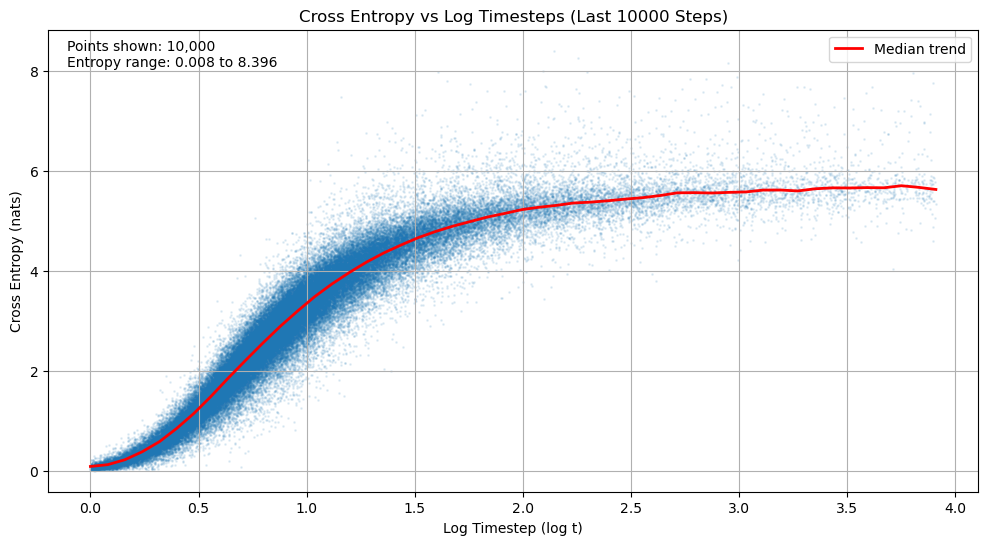

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Get last 10000 points
times = np.array(scheduler.times[-100_000:])
entropy = np.array(scheduler.entropy[-100_000:])

plt.figure(figsize=(12, 6))
plt.scatter(np.log(times), entropy, alpha=0.1, s=1)

# Trend line using log time bins
log_time_bins = np.linspace(np.log(times.min()), np.log(times.max()), 50)
entropy_means = [np.median(entropy[np.abs(np.log(times) - t) < (np.log(times.max())-np.log(times.min()))/50]) for t in log_time_bins]
plt.plot(log_time_bins, entropy_means, 'r-', linewidth=2, label='Median trend')

plt.title('Cross Entropy vs Log Timesteps (Last 10000 Steps)')
plt.xlabel('Log Timestep (log t)')
plt.ylabel('Cross Entropy (nats)')
plt.grid(True)
plt.legend()

plt.text(0.02, 0.98, f'Points shown: 10,000\nEntropy range: {entropy.min():.3f} to {entropy.max():.3f}', 
        transform=plt.gca().transAxes, verticalalignment='top')

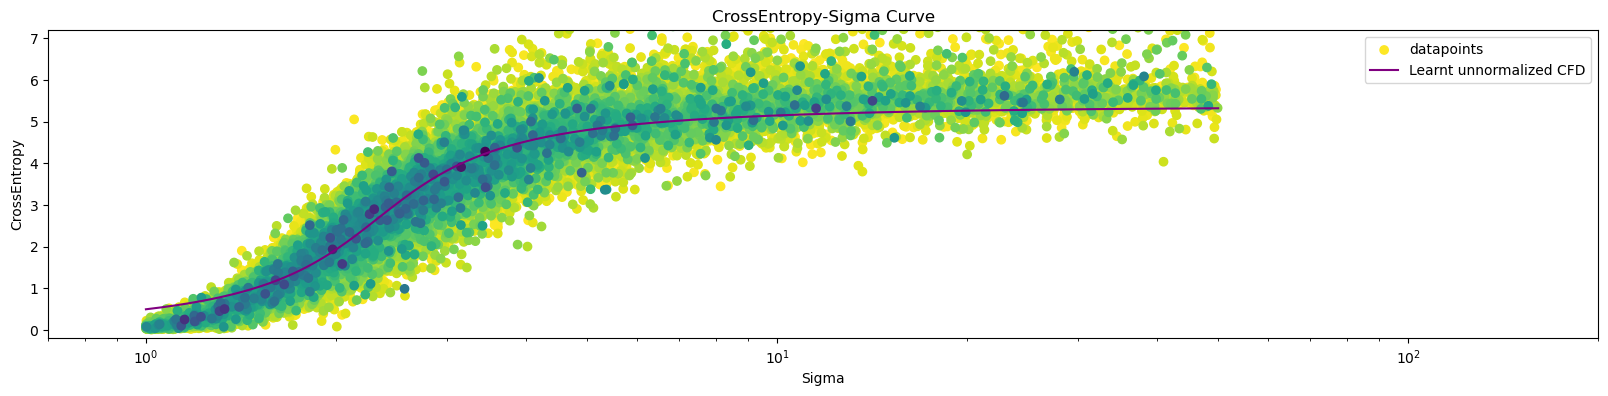

In [17]:
scheduler.plot_entropy_time_curve()

/mnt/mnemo9/mpelus/matlas/cdcd_multi_train/cdcd_hmp/simplifiedV2/scheduler.py:160: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


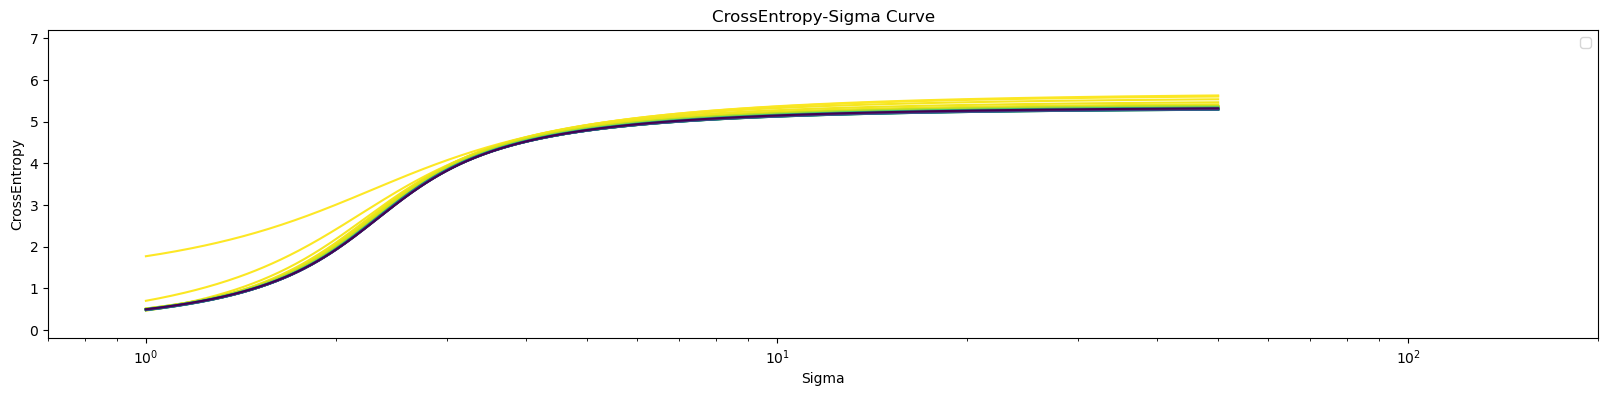

In [18]:
scheduler.plot_training_curves()

In [237]:
def main_diff_loop_part( image, t, timesteps , model):
    # Process time for time embedding
    
    log_t = torch.log(t.squeeze(-1).squeeze(-1) + 1e-8) / 4
    time_emb = model.time_embedding(log_t)
    time_norm = torch.norm(time_emb, p=2, dim=-1, keepdim=True)
    time_emb = (time_emb / (time_norm + 1e-8)) * math.sqrt(model.embedding_dim) #try norming time
    time_emb = time_emb.view(1, 1, -1).expand(image.size(0), image.size(1), -1)

    # Concat time info to noised
    normed_scaled_image = (image / (torch.norm(image, keepdim=True, p=2, dim=-1) + 1e-8)) * math.sqrt(model.embedding_dim)
    current_image = torch.cat([normed_scaled_image, time_emb], dim=-1)

    # Project to transformer dim
    proj_to_transformer_dim = model.embedding_projection(current_image)

    # Calculte 'expected embedding'
    predicted = torch.softmax(model.final_projection(model.transformer(proj_to_transformer_dim)), dim=-1)
    normalized_embeddings = model.token_embedding.weight / torch.norm(model.token_embedding.weight, keepdim=True, p=2, dim=1)
    update = predicted @ normalized_embeddings #model.token_embedding.weight

    #apply update
    dt = timesteps[(timesteps == t).nonzero().item() + 1] - t if (timesteps == t).nonzero().item() < len(timesteps) - 1 else 0
    image = image - dt * ((update - image)/(t**1))

    return image, predicted, update



In [238]:
def generate_sequence(model, scheduler, seq_len=100, n_steps=200, batch_size=1000, device="cuda"):
    # Get timesteps as a 1D sequence
    timesteps = scheduler.make_timesteps(
        n_steps,
        tmin=1,
        tmax=50,
        device=device
    )
    
    # Initialize noise
    image = torch.randn(batch_size, seq_len, model.embedding_dim, device=device) * torch.sqrt(timesteps[0])

    # Diffusion process
    for t in timesteps:
        with torch.no_grad():
            image, predicted, update = main_diff_loop_part(image, t, timesteps, model)
    
    # Final prediction
    with torch.no_grad():
        log_t = torch.log(timesteps[-1].squeeze(-1).squeeze(-1) + 1e-8) / 4
        time_emb = model.time_embedding(log_t)
        time_norm = torch.norm(time_emb, p=2, dim=-1, keepdim=True)
        time_emb = (time_emb / (time_norm + 1e-8)) * math.sqrt(model.embedding_dim)  # try norming time
        time_emb = time_emb.view(1, 1, -1).expand(image.size(0), image.size(1), -1)
        
        current_image = torch.cat([image, time_emb], dim=-1)
        
        proj_to_transformer_dim = model.embedding_projection(current_image)
        
        predicted = torch.softmax(model.final_projection(model.transformer(proj_to_transformer_dim)), dim=-1)
        
        token_ids = torch.argmax(predicted, dim=2)
    
    return token_ids

def generate_sequences_of_different_lengths(model, scheduler, lengths, batch_sizes, n_steps=200, device="cuda"):
    if len(lengths) != len(batch_sizes):
        raise ValueError("lengths and batch_sizes must have the same length")
    
    results = {}
    
    # Generate sequences for each length with its corresponding batch size
    for i, seq_len in enumerate(lengths):
        batch_size = batch_sizes[i]
        token_lists = generate_sequence(
            model=model,
            scheduler=scheduler,
            seq_len=seq_len,
            n_steps=n_steps,
            batch_size=batch_size,
            device=device
        )
        results[seq_len] = token_lists
    
    return results

lengths = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180]
batch_sizes = [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]  # You can customize these values

# Step 1: Generate sequences for different lengths with specified batch sizes
sequences_dict = generate_sequences_of_different_lengths(
    model, scheduler, lengths, batch_sizes, n_steps=100
)

# Step 2: Convert PyTorch tensors to lists for all sequences (if needed)
all_sequences = []

for length, seqs in sequences_dict.items():
    # Convert tensor to list if it's not already
    if isinstance(seqs, torch.Tensor):
        seq_lists = seqs.cpu().tolist()
    else:
        seq_lists = seqs
    
    # Add all sequences from this length
    all_sequences.extend(seq_lists)

Processing 700 sequences of various lengths
Found 518 unique tokens across all sequences
Diagonal values min: 1.0, max: 1.0
Off-diagonal similarity statistics:
  Min: 0.0000
  Max: 0.5909
  Mean: 0.1272
  Median: 0.1064
Performing hierarchical clustering...


/tmp/ipykernel_2215510/4244586275.py:67: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


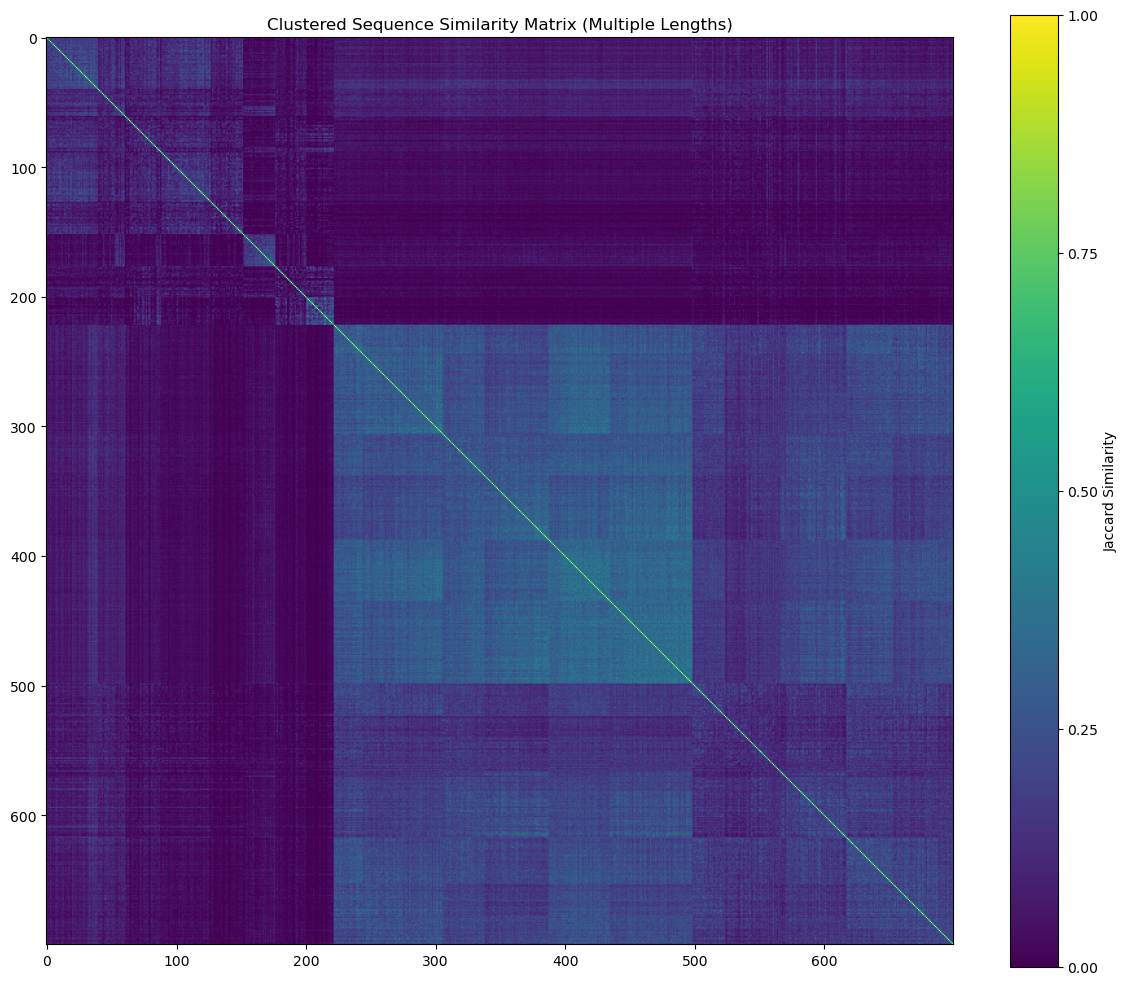

Applying UMAP...


/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [239]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import umap
import time
from matplotlib.colors import Normalize

start_time = time.time()

# Use the list of sequences directly
sequences = all_sequences
batch_size = len(sequences)

print(f"Processing {batch_size} sequences of various lengths")

# Get all unique tokens across all sequences
all_tokens = set()
for seq in sequences:
    all_tokens.update(seq)
all_tokens = list(all_tokens)
vocab_size = len(all_tokens)
print(f"Found {vocab_size} unique tokens across all sequences")

# Create a mapping from token to index for faster lookups
token_to_idx = {token: idx for idx, token in enumerate(all_tokens)}

# Create binary representation using vectorized operations
binary_features = np.zeros((batch_size, vocab_size), dtype=bool)

for i, seq in enumerate(sequences):
    # Get unique tokens in this sequence
    unique_tokens_in_seq = set(seq)
    # Convert tokens to indices in our vocabulary
    token_indices = [token_to_idx[token] for token in unique_tokens_in_seq]
    # Set corresponding positions to True
    for idx in token_indices:
        binary_features[i, idx] = True

# Compute Jaccard similarity matrix
similarity_matrix = np.zeros((batch_size, batch_size))

# Only compute upper triangle (including diagonal)
for i in range(batch_size):
    similarity_matrix[i, i] = 1.0  # Diagonal is always 1
    for j in range(i+1, batch_size):
        intersection = np.sum(binary_features[i] & binary_features[j])
        union = np.sum(binary_features[i] | binary_features[j])
        sim = intersection / union if union > 0 else 0.0
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim  # Fill in the lower triangle

# Verify diagonal values
diagonal_values = np.diagonal(similarity_matrix)
print(f"Diagonal values min: {diagonal_values.min()}, max: {diagonal_values.max()}")

# Calculate statistics
off_diagonal = similarity_matrix[~np.eye(batch_size, dtype=bool)]
print(f"Off-diagonal similarity statistics:")
print(f"  Min: {off_diagonal.min():.4f}")
print(f"  Max: {off_diagonal.max():.4f}")
print(f"  Mean: {off_diagonal.mean():.4f}")
print(f"  Median: {np.median(off_diagonal):.4f}")

# Perform hierarchical clustering
print("Performing hierarchical clustering...")
distance_matrix = 1 - similarity_matrix
Z = linkage(distance_matrix, method='ward')

# Determine optimal number of clusters
n_clusters = min(20, batch_size)
cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')

# Reorder the similarity matrix based on clustering
idx_to_cluster = [(i, cluster_labels[i]) for i in range(batch_size)]
idx_to_cluster.sort(key=lambda x: x[1])  # Sort by cluster
sorted_indices = [idx for idx, _ in idx_to_cluster]

sorted_similarity = similarity_matrix[sorted_indices, :][:, sorted_indices]

# Plot clustered similarity matrix
plt.figure(figsize=(12, 10))
im = plt.imshow(sorted_similarity, cmap='viridis', vmin=0, vmax=1)
colorbar = plt.colorbar(im, label="Jaccard Similarity")
colorbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
plt.title("Clustered Sequence Similarity Matrix (Multiple Lengths)")
plt.tight_layout()
plt.show()

# Apply UMAP with precomputed distances
print("Applying UMAP...")
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=min(15, batch_size-1),
    min_dist=0.1,
    metric='precomputed',
    random_state=42
)

embedding = reducer.fit_transform(distance_matrix)

# Get sequence lengths for continuous coloring
seq_lengths = np.array([len(seq) for seq in sequences])
min_length = min(seq_lengths)
max_length = max(seq_lengths)

# Create a continuous colormap for sequence lengths
norm = Normalize(vmin=min_length, vmax=max_length)

# Visualize UMAP results with continuous length coloring
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], s=50, alpha=0.8, 
                     c=seq_lengths, cmap='viridis', norm=norm)
cbar = plt.colorbar(scatter, label="Sequence Length")
cbar.set_ticks(np.linspace(min_length, max_length, 10).astype(int))
plt.title("UMAP Projection of Sequences Colored by Length (Continuous)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# Also visualize with cluster coloring
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], s=50, alpha=0.8, 
                     c=cluster_labels, cmap='tab20')
plt.colorbar(scatter, label="Cluster")
plt.title("UMAP Projection of Sequences Colored by Cluster")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

print(f"Total execution time: {time.time() - start_time:.2f} seconds")

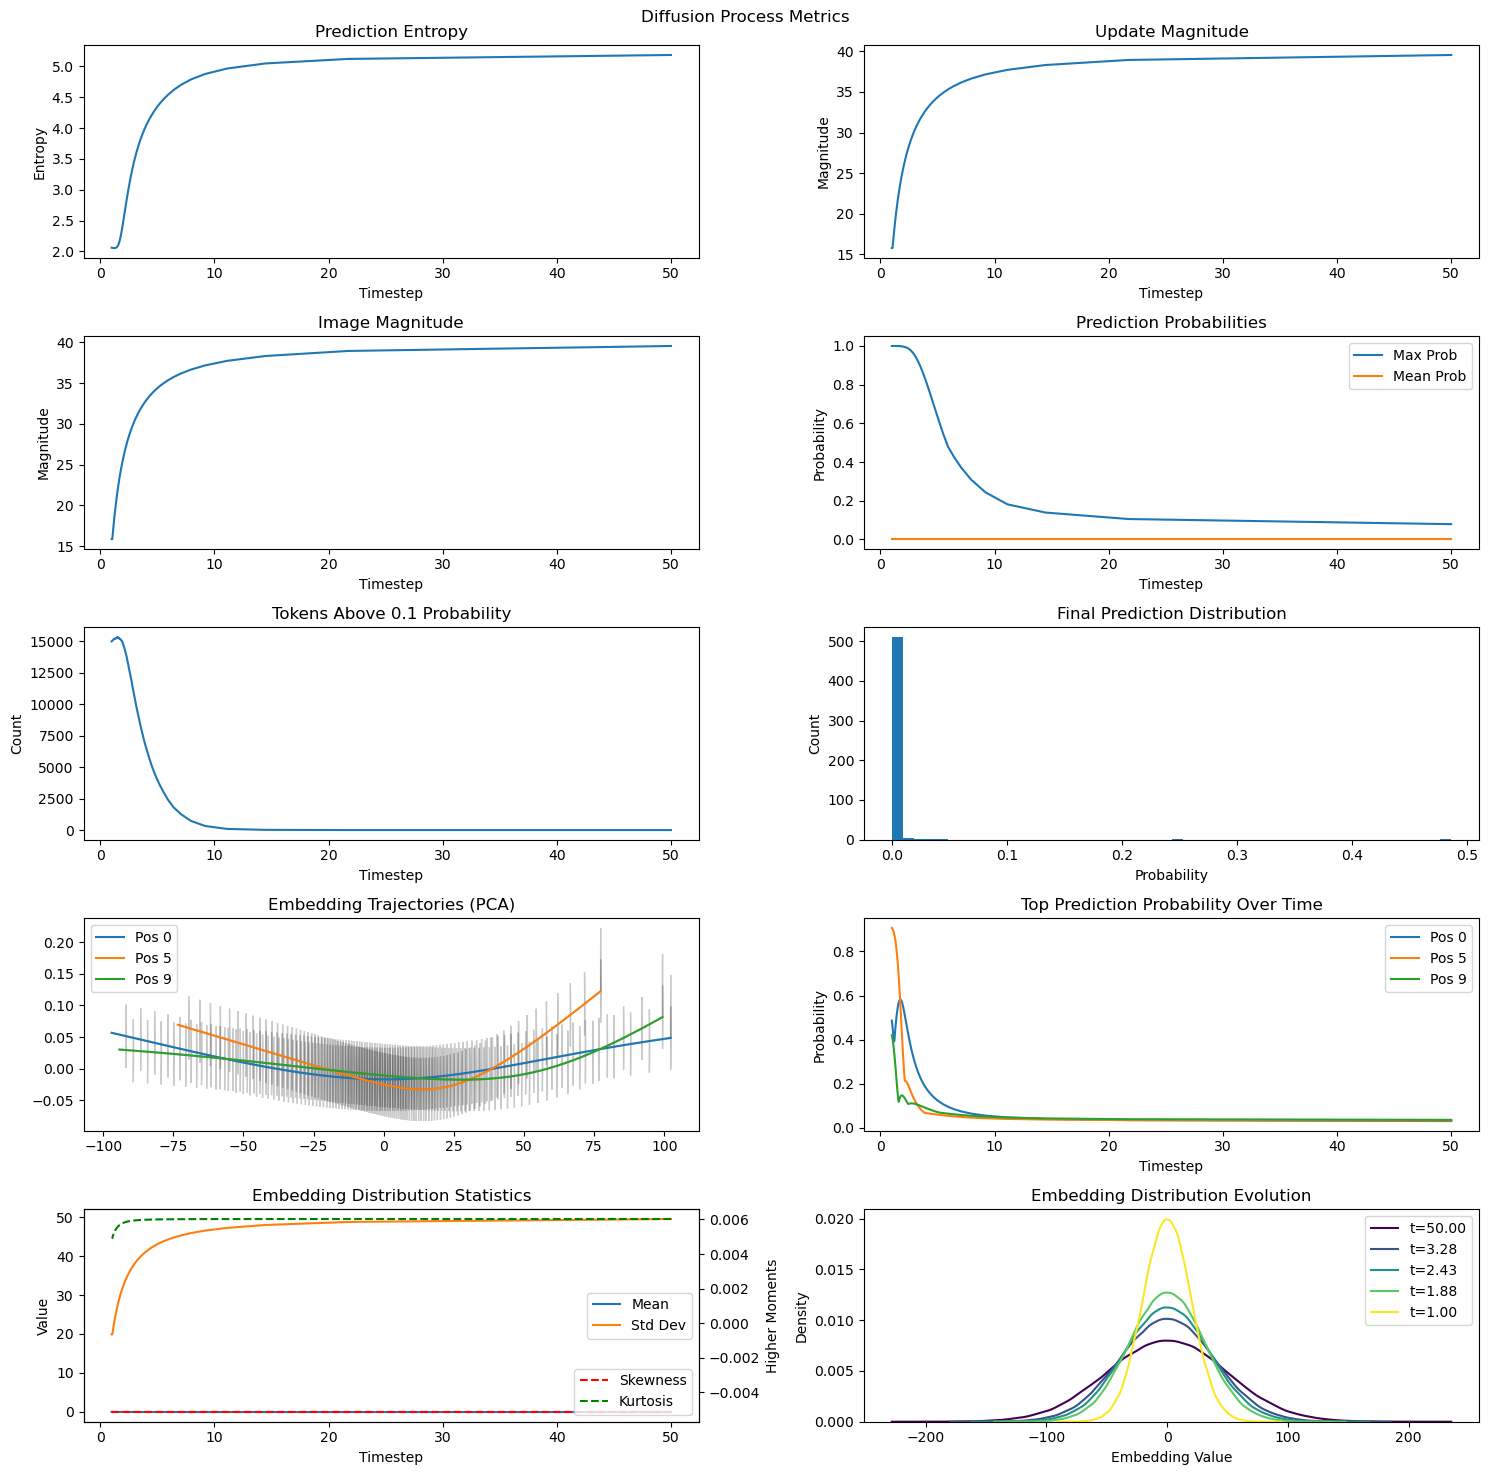

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

n_steps = 100
timesteps = scheduler.make_timesteps(
    n_steps,
    tmin=1,#t_min,
    tmax= 50,#t_max,
    device=device
)
seq_len = 10

timestep_values = []
prediction_entropy = []
update_magnitudes = []
image_magnitudes = []
max_probs = []
mean_probs = []
tokens_above_threshold = []
# Add these lists to your existing metric trackers
embedding_mean = []
embedding_std = []
embedding_skew = []
embedding_kurtosis = []
embedding_histograms = []  # Store histogram data for key timesteps

positions_to_track = [0, 5, 9]  # Track first, middle, and last positions
trajectory_embeddings = {pos: [] for pos in positions_to_track}
trajectory_predictions = {pos: [] for pos in positions_to_track}

#adjustor = torch.randn(batch_size, seq_len, model.embedding_dim, device=device)
image = torch.randn(batch_size, seq_len, model.embedding_dim, device=device) * timesteps[0]
#image = (image + adjustor)/(torch.sqrt(t**2 + 1))
for t in timesteps:
    with torch.no_grad():
        
        image, predicted, update = main_diff_loop_part(image, t, timesteps, model)
        
        # Collect metrics
        timestep_values.append(t.item())
        entropy = (-predicted * torch.log(predicted + 1e-8)).sum(-1).mean().item()
        prediction_entropy.append(entropy)
        update_mag = (update - image).abs().mean().item()
        update_magnitudes.append(update_mag)
        image_magnitudes.append(image.abs().mean().item())
        max_probs.append(predicted.max().item())
        mean_probs.append(predicted.mean().item())
        tokens_above_threshold.append((predicted > 0.1).float().sum().item())
        embedding_values = image.detach().cpu().numpy().flatten()
        embedding_mean.append(np.mean(embedding_values))
        embedding_std.append(np.std(embedding_values))
        embedding_skew.append(stats.skew(embedding_values))
        embedding_kurtosis.append(stats.kurtosis(embedding_values))
        # Store histogram data at specific timesteps (e.g., beginning, middle, end)
        if len(embedding_histograms) < 5 and (
                t == timesteps[0] or 
                t == timesteps[len(timesteps)//4] or 
                t == timesteps[len(timesteps)//2] or
                t == timesteps[3*len(timesteps)//4] or
                t == timesteps[-1]):
            embedding_histograms.append((t.item(), embedding_values))
        
        # Track trajectories
        for pos in positions_to_track:
            trajectory_embeddings[pos].append(image[0, pos].cpu().numpy())
            trajectory_predictions[pos].append(predicted[0, pos].cpu().numpy())


# Create subplots

# Create a new row in your subplot grid - adjust the figure size and grid
fig, axes = plt.subplots(5, 2, figsize=(15, 15))  # Increased to 5 rows
fig.suptitle('Diffusion Process Metrics')

# Plot metrics
axes[0,0].plot(timestep_values, prediction_entropy)
axes[0,0].set_title('Prediction Entropy')
axes[0,0].set_xlabel('Timestep')
axes[0,0].set_ylabel('Entropy')

axes[0,1].plot(timestep_values, update_magnitudes)
axes[0,1].set_title('Update Magnitude')
axes[0,1].set_xlabel('Timestep')
axes[0,1].set_ylabel('Magnitude')

axes[1,0].plot(timestep_values, image_magnitudes)
axes[1,0].set_title('Image Magnitude')
axes[1,0].set_xlabel('Timestep')
axes[1,0].set_ylabel('Magnitude')

axes[1,1].plot(timestep_values, max_probs)
axes[1,1].plot(timestep_values, mean_probs)
axes[1,1].set_title('Prediction Probabilities')
axes[1,1].set_xlabel('Timestep')
axes[1,1].set_ylabel('Probability')
axes[1,1].legend(['Max Prob', 'Mean Prob'])

axes[2,0].plot(timestep_values, tokens_above_threshold)
axes[2,0].set_title('Tokens Above 0.1 Probability')
axes[2,0].set_xlabel('Timestep')
axes[2,0].set_ylabel('Count')

# Plot prediction distribution at final timestep
final_pred = predicted[0][0].cpu().numpy()
axes[2,1].hist(final_pred, bins=50)
axes[2,1].set_title('Final Prediction Distribution')
axes[2,1].set_xlabel('Probability')
axes[2,1].set_ylabel('Count')


# New trajectory plots
# Embedding trajectories
trajectory_data = np.array([trajectory_embeddings[pos] for pos in positions_to_track])
# Use PCA to reduce embedding dimension for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
trajectory_2d = [pca.fit_transform(traj) for traj in trajectory_data]

for i, pos in enumerate(positions_to_track):
    axes[3,0].plot(trajectory_2d[i][:, 0], trajectory_2d[i][:, 1], label=f'Pos {pos}')
    # Add arrows to show direction
    for j in range(len(trajectory_2d[i])-1):
        axes[3,0].arrow(trajectory_2d[i][j, 0], trajectory_2d[i][j, 1],
                       trajectory_2d[i][j+1, 0] - trajectory_2d[i][j, 0],
                       trajectory_2d[i][j+1, 1] - trajectory_2d[i][j, 1],
                       head_width=0.1, head_length=0.1, fc='k', ec='k', alpha=0.2)
axes[3,0].set_title('Embedding Trajectories (PCA)')
axes[3,0].legend()

# Top prediction probabilities over time
for pos in positions_to_track:
    top_probs = [np.max(pred) for pred in trajectory_predictions[pos]]
    axes[3,1].plot(timestep_values, top_probs, label=f'Pos {pos}')
axes[3,1].set_title('Top Prediction Probability Over Time')
axes[3,1].set_xlabel('Timestep')
axes[3,1].set_ylabel('Probability')
axes[3,1].legend()




# Add embedding distribution statistics plot
axes[4,0].plot(timestep_values, embedding_mean, label='Mean')
axes[4,0].plot(timestep_values, embedding_std, label='Std Dev')
axes[4,0].set_title('Embedding Distribution Statistics')
axes[4,0].set_xlabel('Timestep')
axes[4,0].set_ylabel('Value')
axes[4,0].legend()

# Add higher moments on a secondary axis for better visualization
ax2 = axes[4,0].twinx()
ax2.plot(timestep_values, embedding_skew, 'r--', label='Skewness')
ax2.plot(timestep_values, embedding_kurtosis, 'g--', label='Kurtosis')
ax2.set_ylabel('Higher Moments')
ax2.legend(loc='lower right')

# Create histogram evolution plot
axes[4,1].set_title('Embedding Distribution Evolution')
colors = plt.cm.viridis(np.linspace(0, 1, len(embedding_histograms)))
for i, (t_val, values) in enumerate(embedding_histograms):
    sns.kdeplot(values, ax=axes[4,1], color=colors[i], label=f't={t_val:.2f}')
axes[4,1].legend()
axes[4,1].set_xlabel('Embedding Value')
axes[4,1].set_ylabel('Density')

plt.tight_layout()
plt.show()

Embedding shape: (519, 32)
Mean: 0.0013121448
Std: 0.08409854
Min: -0.24911495
Max: 0.26727417


/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


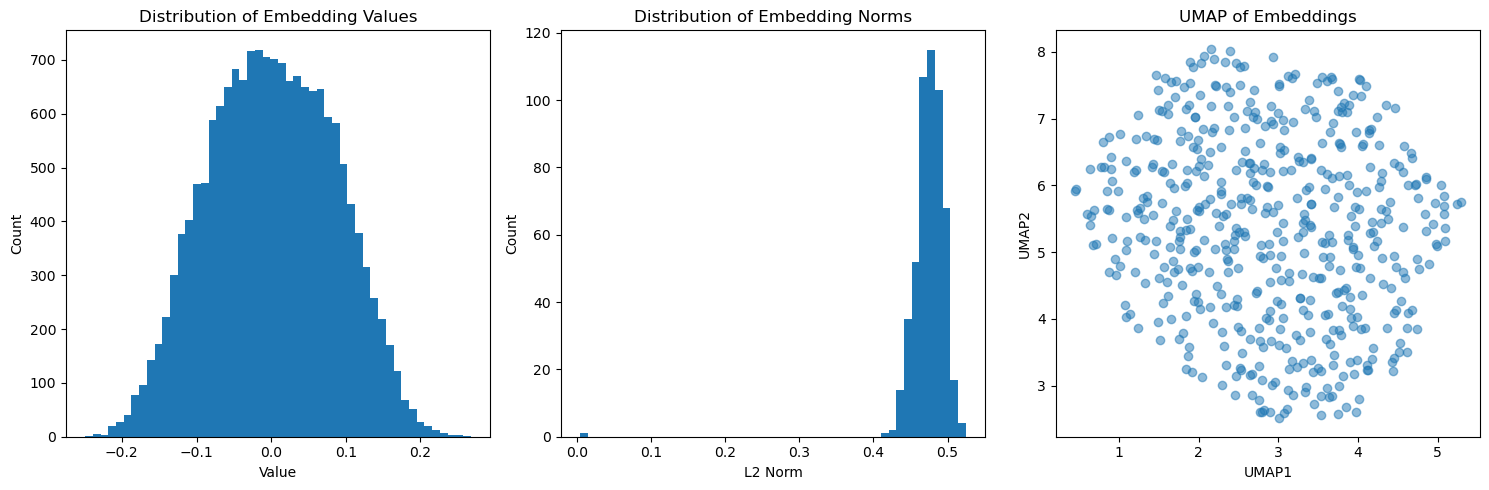

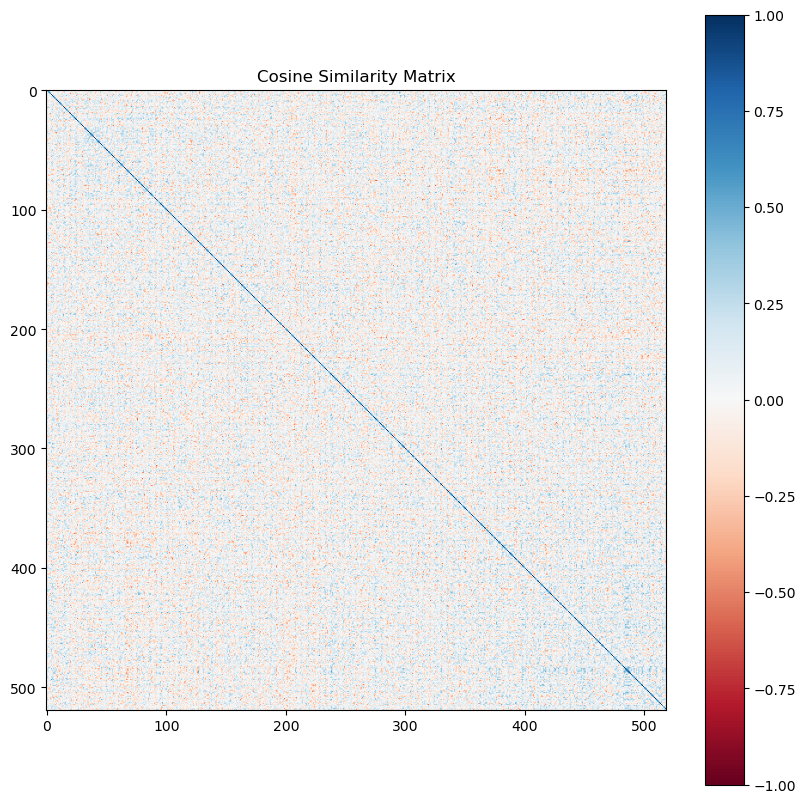

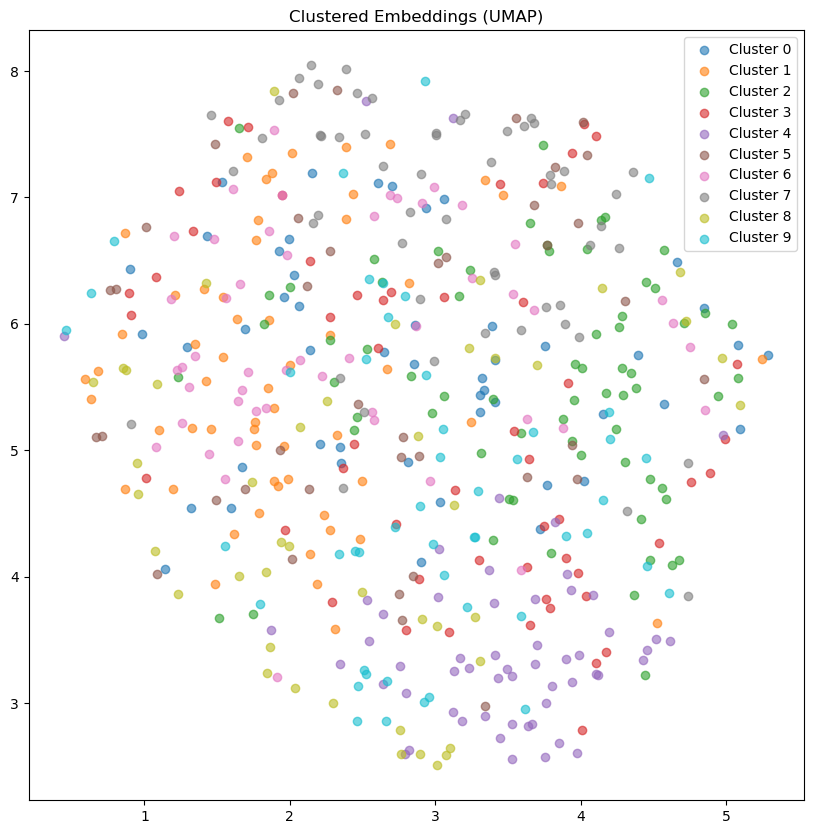

In [ ]:
# Get the embedding weights
embeddings = model.token_embedding.weight.detach().cpu().numpy()

# Basic statistics
print("Embedding shape:", embeddings.shape)
print("Mean:", np.mean(embeddings))
print("Std:", np.std(embeddings))
print("Min:", np.min(embeddings))
print("Max:", np.max(embeddings))

# Distribution analysis
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(embeddings.flatten(), bins=50)
plt.title('Distribution of Embedding Values')
plt.xlabel('Value')
plt.ylabel('Count')

# Norm analysis
norms = np.linalg.norm(embeddings, axis=1)
plt.subplot(132)
plt.hist(norms, bins=50)
plt.title('Distribution of Embedding Norms')
plt.xlabel('L2 Norm')
plt.ylabel('Count')

# UMAP of the embedding space instead of PCA
import umap
reducer = umap.UMAP(n_components=2, random_state=42, metric='cosine')
embeddings_2d = reducer.fit_transform(embeddings)
plt.subplot(133)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title('UMAP of Embeddings')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.tight_layout()
plt.show()

# Cosine similarity analysis
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(embeddings)
plt.figure(figsize=(10, 10))
plt.imshow(sim_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Cosine Similarity Matrix')
plt.show()

# Check for any obvious clusters
from sklearn.cluster import KMeans
n_clusters = 10  # adjust as needed
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(embeddings)

plt.figure(figsize=(10, 10))
for i in range(n_clusters):
    mask = clusters == i
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], label=f'Cluster {i}', alpha=0.6)
plt.title('Clustered Embeddings (UMAP)')
plt.legend()
plt.show()

Cosine Similarity Matrix Statistics:
Shape: (519, 519)
Mean: 0.0171
Median: 0.0218
Standard Deviation: 0.1826
Min: -0.7428
Max: 1.0000
25th Percentile: -0.1053
75th Percentile: 0.1424

Negative similarities: 122078 (45.41%)
Positive similarities: 147283 (54.78%)
Zero similarities: 0 (0.00%)

Diagonal mean: 1.0000
Diagonal min: 1.0000
Diagonal max: 1.0000


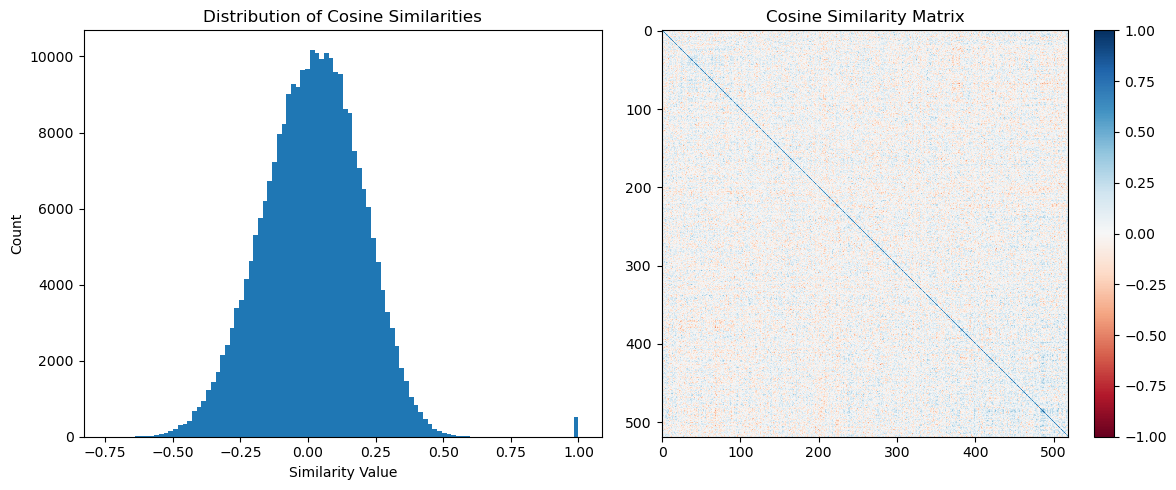

In [ ]:
# Cosine similarity analysis
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(embeddings)

# Print statistics about the similarity matrix
print("Cosine Similarity Matrix Statistics:")
print(f"Shape: {sim_matrix.shape}")
print(f"Mean: {np.mean(sim_matrix):.4f}")
print(f"Median: {np.median(sim_matrix):.4f}")
print(f"Standard Deviation: {np.std(sim_matrix):.4f}")
print(f"Min: {np.min(sim_matrix):.4f}")
print(f"Max: {np.max(sim_matrix):.4f}")
print(f"25th Percentile: {np.percentile(sim_matrix, 25):.4f}")
print(f"75th Percentile: {np.percentile(sim_matrix, 75):.4f}")

# Count negative and positive similarities
neg_count = np.sum(sim_matrix < 0)
pos_count = np.sum(sim_matrix > 0)
zero_count = np.sum(sim_matrix == 0)
total = sim_matrix.size - sim_matrix.shape[0]  # Exclude diagonal (always 1.0)

print(f"\nNegative similarities: {neg_count} ({neg_count/total*100:.2f}%)")
print(f"Positive similarities: {pos_count} ({pos_count/total*100:.2f}%)")
print(f"Zero similarities: {zero_count} ({zero_count/total*100:.2f}%)")

# Diagonal values (should all be 1.0 for cosine similarity)
diag_vals = np.diag(sim_matrix)
print(f"\nDiagonal mean: {np.mean(diag_vals):.4f}")
print(f"Diagonal min: {np.min(diag_vals):.4f}")
print(f"Diagonal max: {np.max(diag_vals):.4f}")

# Plot histogram of values
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(sim_matrix.flatten(), bins=100)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Similarity Value')
plt.ylabel('Count')

# Show the similarity matrix
plt.subplot(122)
plt.imshow(sim_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Cosine Similarity Matrix')
plt.tight_layout()
plt.show()

Cosine similarity range: -0.743 to 1.000


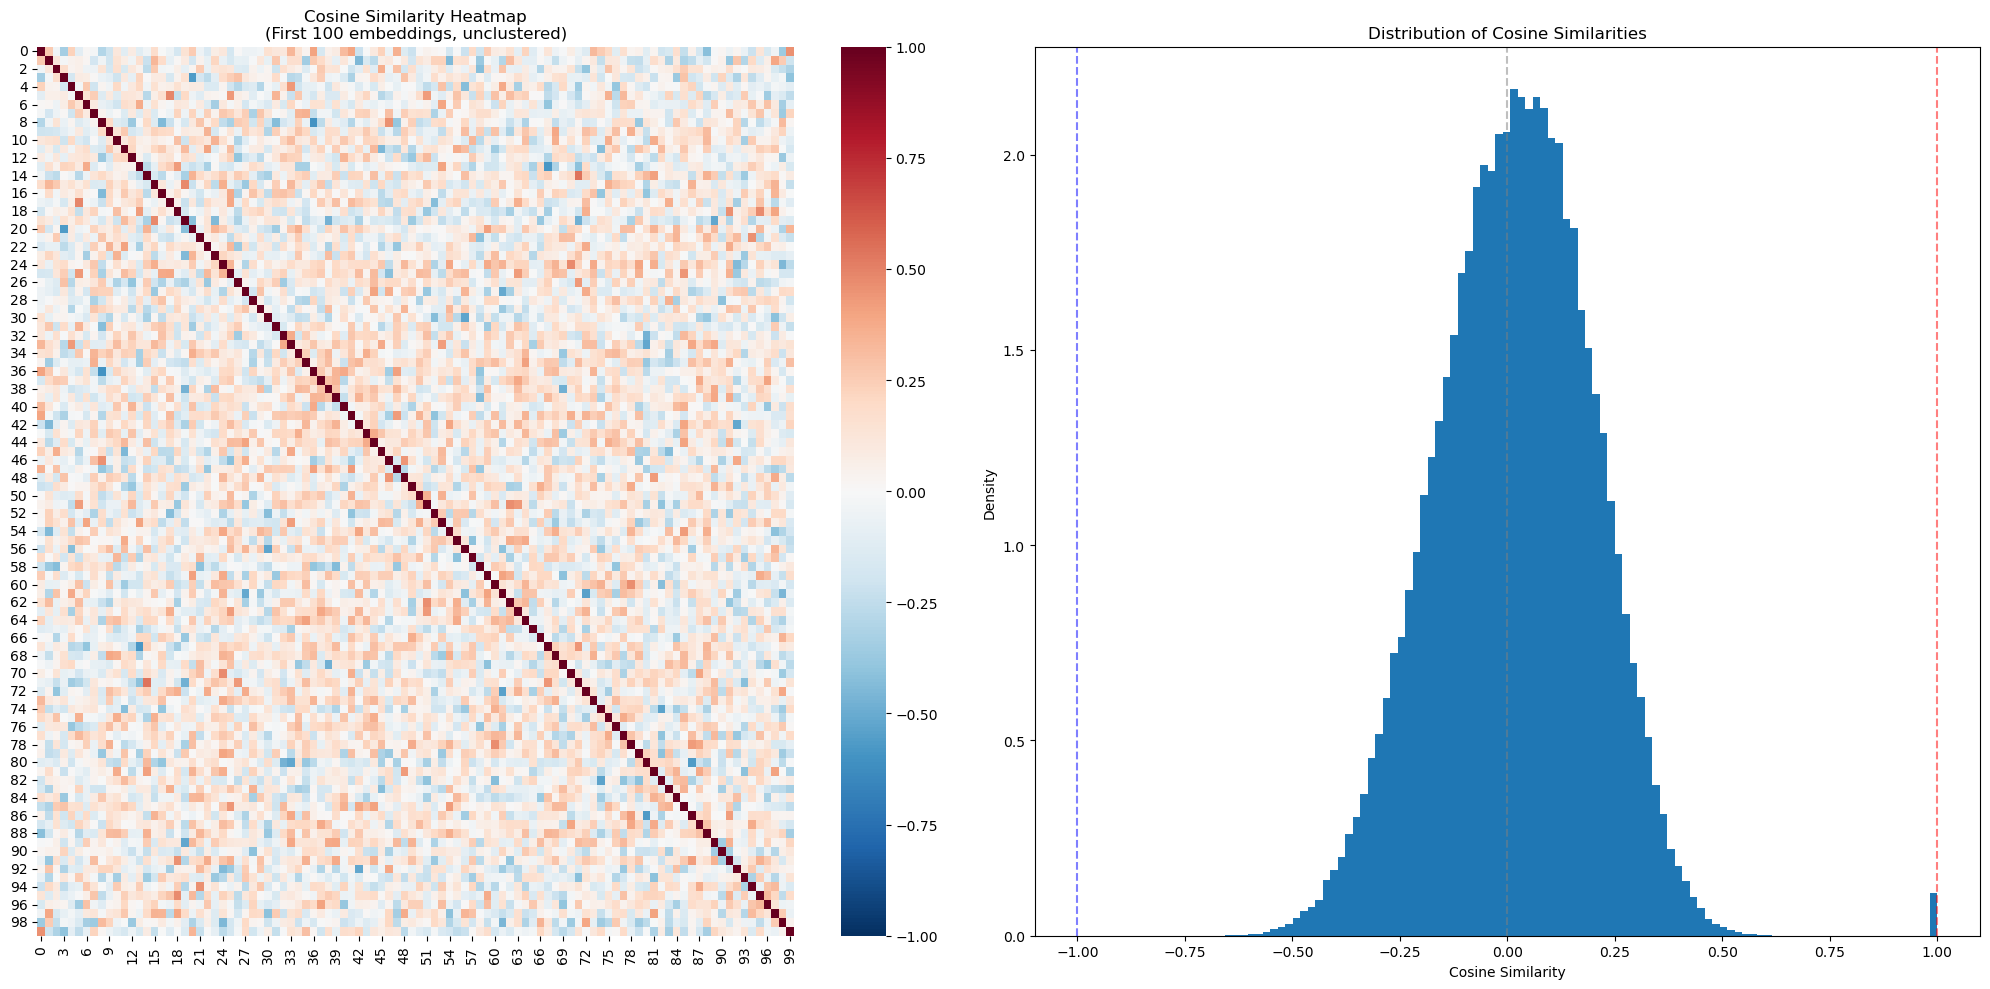

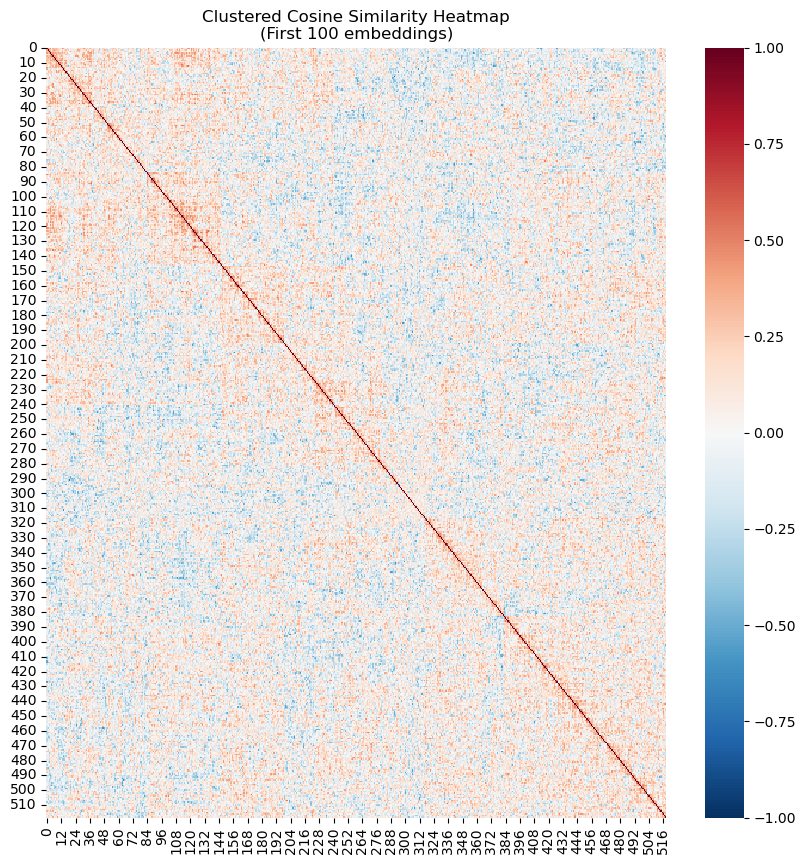

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

def plot_cosine_similarities_full_range(embeddings):
    # Calculate cosine similarity matrix
    cosine_sim = cosine_similarity(embeddings)
    
    # Print range statistics
    print(f"Cosine similarity range: {cosine_sim.min():.3f} to {cosine_sim.max():.3f}")
    
    # Create figure
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Full heatmap
    plt.subplot(121)
    sns.heatmap(cosine_sim[:100, :100],  # Using first 100x100 for better visibility
                cmap='RdBu_r',
                vmin=-1,
                vmax=1,
                center=0)
    plt.title('Cosine Similarity Heatmap\n(First 100 embeddings, unclustered)')
    
    # Plot 2: Distribution
    plt.subplot(122)
    plt.hist(cosine_sim.flatten(), bins=100, density=True)
    plt.title('Distribution of Cosine Similarities')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    
    # Add vertical lines for reference
    plt.axvline(x=-1, color='blue', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=1, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

    # Now show clustered version
    plt.figure(figsize=(10, 10))
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(cosine_sim, method='ward')
    den = dendrogram(linkage_matrix, no_plot=True)
    reordered_idx = den['leaves']
    
    # Reorder the similarity matrix
    cosine_sim_clustered = cosine_sim[reordered_idx][:, reordered_idx]
    
    # Plot clustered heatmap
    sns.heatmap(cosine_sim_clustered[:519, :519],  # Using first 100x100 for better visibility
                cmap='RdBu_r',
                vmin=-1,
                vmax=1,
                center=0)
    plt.title('Clustered Cosine Similarity Heatmap\n(First 100 embeddings)')
    plt.show()

# Run the analysis
plot_cosine_similarities_full_range(embeddings)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

n_trajectories = 5
n_steps = 50
all_trajectories = []
positions_to_track = [0, 5, 10]

# Initialize different starting points
for i in range(n_trajectories):
    timestep_values = []
    trajectory_embeddings = {pos: [] for pos in positions_to_track}
    trajectory_updates = {pos: [] for pos in positions_to_track}
    
    # Try different initial scales
    scale = timesteps[0] * (i + 1) / n_trajectories
    image = torch.randn(batch_size, seq_len, model.embedding_dim, device=device) * scale
    
    for t in timesteps:
        with torch.no_grad():
            image, predicted, update = main_diff_loop_part(image, t, timesteps, model)
            
            # Track trajectories and updates
            for pos in positions_to_track:
                trajectory_embeddings[pos].append(image[0, pos].cpu().numpy())
                trajectory_updates[pos].append((update - image)[0, pos].cpu().numpy())
            
            timestep_values.append(t.item())
            
            
    
    all_trajectories.append((trajectory_embeddings, trajectory_updates))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Multiple Trajectory Analysis')

# Plot all trajectories in PCA space
pca = PCA(n_components=2)
all_points = []
for traj, _ in all_trajectories:
    for pos in positions_to_track:
        all_points.extend(traj[pos])
all_points = np.array(all_points)
pca.fit(all_points)

for i, (traj, updates) in enumerate(all_trajectories):
    for pos in positions_to_track:
        trajectory_2d = pca.transform(traj[pos])
        axes[0,0].plot(trajectory_2d[:, 0], trajectory_2d[:, 1], 
                      label=f'Traj {i}, Pos {pos}', alpha=0.5)
        # Add arrows for direction
        for j in range(len(trajectory_2d)-1):
            axes[0,0].arrow(trajectory_2d[j, 0], trajectory_2d[j, 1],
                          trajectory_2d[j+1, 0] - trajectory_2d[j, 0],
                          trajectory_2d[j+1, 1] - trajectory_2d[j, 1],
                          head_width=0.1, head_length=0.1, fc='k', ec='k', alpha=0.1)
axes[0,0].set_title('All Trajectories (PCA)')
axes[0,0].legend()

# Plot update vector magnitudes over time
for i, (_, updates) in enumerate(all_trajectories):
    for pos in positions_to_track:
        update_mags = [np.linalg.norm(u) for u in updates[pos]]
        axes[0,1].plot(timestep_values, update_mags, 
                      label=f'Traj {i}, Pos {pos}', alpha=0.5)
axes[0,1].set_title('Update Vector Magnitudes')
axes[0,1].set_xlabel('Timestep')
axes[0,1].set_ylabel('Magnitude')
axes[0,1].legend()

# Plot final states
final_states = []
for traj, _ in all_trajectories:
    for pos in positions_to_track:
        final_states.append(traj[pos][-1])
final_states = np.array(final_states)
final_states_2d = pca.transform(final_states)
axes[1,0].scatter(final_states_2d[:, 0], final_states_2d[:, 1], alpha=0.6)
axes[1,0].set_title('Final States Distribution')

# Plot update vector directions over time
# Take a single position for clarity
pos_to_analyze = positions_to_track[0]
for i, (_, updates) in enumerate(all_trajectories):
    update_directions = []
    for j in range(len(updates[pos_to_analyze])-1):
        u1 = updates[pos_to_analyze][j]
        u2 = updates[pos_to_analyze][j+1]
        cos_sim = np.dot(u1, u2) / (np.linalg.norm(u1) * np.linalg.norm(u2))
        update_directions.append(cos_sim)
    axes[1,1].plot(timestep_values[:-1], update_directions, 
                   label=f'Traj {i}', alpha=0.5)
axes[1,1].set_title('Update Direction Consistency')
axes[1,1].set_xlabel('Timestep')
axes[1,1].set_ylabel('Cosine Similarity between consecutive updates')
axes[1,1].legend()

plt.tight_layout()
plt.show()

IndexError: index 10 is out of bounds for dimension 1 with size 10

In [ ]:
# Get the weights of the embedding projection layer
if isinstance(model.embedding_projection, nn.Linear):
    projection_weights = model.embedding_projection.weight.detach().cpu().numpy()
else:
    print("No projection weights to extract - embedding_projection is an Identity layer")

# The weights should be split between token embedding dims and time embedding dims
n_token_dims = model.embedding_dim  # 32 from earlier
n_time_dims = projection_weights.shape[1] - n_token_dims



print("Token weight section shape:", token_weights.shape)
print("Time embedding section shape:", time_weights.shape)

# Compare statistics
print("\nToken weights stats:")
print("Mean:", np.mean(token_weights))
print("Std:", np.std(token_weights))
print("Abs mean:", np.mean(np.abs(token_weights)))

print("\nTime weights stats:")
print("Mean:", np.mean(time_weights))
print("Std:", np.std(time_weights))
print("Abs mean:", np.mean(np.abs(time_weights)))

# Visualize the relative magnitudes
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(token_weights.flatten(), bins=50, alpha=0.5, label='Token weights')
plt.hist(time_weights.flatten(), bins=50, alpha=0.5, label='Time weights')
plt.title('Distribution of Weight Values')
plt.legend()

plt.subplot(132)
plt.imshow(np.abs(token_weights), aspect='auto')
plt.title('Token Weight Magnitudes')
plt.colorbar()

plt.subplot(133)
plt.imshow(np.abs(time_weights), aspect='auto')
plt.title('Time Weight Magnitudes')
plt.colorbar()

plt.tight_layout()
plt.show()

No projection weights to extract - embedding_projection is an Identity layer


NameError: name 'projection_weights' is not defined

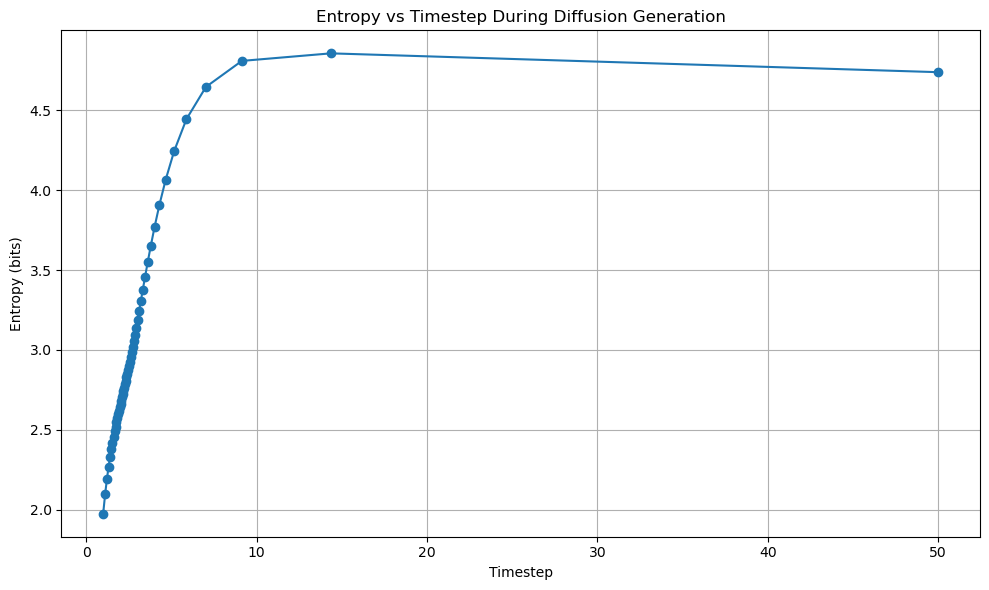

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_entropy_vs_timesteps(
    model,
    scheduler,
    batch_size=1,
    seq_len=10,
    n_steps=50,
    t_min=None,
    t_max=None,
    device="cuda"
):
    """
    Generate samples and plot entropy against timesteps.
    
    Args:
        model: The diffusion model
        scheduler: Timestep scheduler
        batch_size: Number of samples to generate in parallel
        seq_len: Length of each generated sequence
        n_steps: Number of diffusion steps
        t_min: Minimum timestep value
        t_max: Maximum timestep value
        device: Device to run generation on
    """
    # Get timesteps
    timesteps = scheduler.make_timesteps(
        n_steps,
        tmin=t_min,
        tmax=t_max,
        device=device
    )
    
    # Initialize storage for entropy values
    entropy_values = []
    timestep_values = []
    
    # Initialize noise
    image = torch.randn(batch_size, seq_len, model.embedding_dim, device=device) * timesteps[0]

    def calculate_entropy(probs):
        """Calculate entropy from probability distribution"""
        eps = 1e-10
        entropy = -torch.sum(probs * torch.log2(probs + eps), dim=-1)
        return entropy.mean().item()

    for t in timesteps:
        with torch.no_grad():
            #image = (image / (torch.norm(image, keepdim=True, p=2, dim=-1) + 1e-8)) * math.sqrt(model.embedding_dim)

            image, predicted, update = main_diff_loop_part(image, t, timesteps, model)
            
            # Calculate and store entropy
            entropy = calculate_entropy(predicted)
            entropy_values.append(entropy)
            timestep_values.append(t.item())
            
            
            

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(timestep_values, entropy_values, '-o')
    plt.xlabel('Timestep')
    plt.ylabel('Entropy (bits)')
    plt.title('Entropy vs Timestep During Diffusion Generation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return entropy_values, timestep_values

# Example usage
entropy_values, timestep_values = plot_entropy_vs_timesteps(
    model,
    scheduler,
    batch_size=1,
    seq_len=200,
    n_steps=50,
    t_min =1,
    t_max = 50
)